### Naive_Bayes

In [1]:
import os

def load_data(data_dir):
    data = []
    for topic in os.listdir(data_dir):
        topic_dir = os.path.join(data_dir, topic)
        for fname in os.listdir(topic_dir):
            with open(os.path.join(topic_dir, fname)) as f:
                # Ignore the header
                for line in f:
                    if not line.strip():
                        break

                # Read the rest of the post
                post = f.read()
                data.append((topic, post))
    return data

train_data = load_data('20news-bydate-train')
test_data = load_data('20news-bydate-test')

### Preprocessing



In [2]:
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def preprocess(text):
    # Convert words to lower case
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove words that are one character or less
    text = re.sub(r'\b\w{1,2}\b', '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([w for w in text.split() if w not in stop_words])

    # Stem words
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(w) for w in text.split()])

    return text

train_data = [(topic, preprocess(post)) for topic, post in train_data]
test_data = [(topic, preprocess(post)) for topic, post in test_data]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mati1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Creating the vocabulary



In [3]:
from collections import Counter

def create_vocabulary(data, max_words = 10000):
    # Create a list of all the words in the data
    all_words = [word for _, post in data for word in post.split()]

    # Create a dictionary mapping each word to its frequency
    word_counts = Counter(all_words)

    # Sort the words by frequency in descending order
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Get the words
    words = [x[0] for x in sorted_word_counts]

    return words[:max_words]


vocabulary = create_vocabulary(train_data)

### Creating the feature vectors



In [4]:
def document_features(document):
    document_words = Counter(document.split())
    features = [document_words[word] for word in vocabulary]
    return features

train_features = [(document_features(post), topic) for topic, post in train_data]
test_features = [(document_features(post), topic) for topic, post in test_data]

### Training the classifier



In [5]:
topics = list(set([topic for topic, _ in train_data]))
train_labels = [topics.index(topic) for _, topic in train_features]
test_labels = [topics.index(topic) for _, topic in test_features]

In [6]:
train_samples = [features for features, _ in train_features]
test_samples = [features for features, _ in test_features]

In [7]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(train_samples, train_labels)

MultinomialNB()

### Evaluating the classifier



In [8]:
from sklearn.metrics import accuracy_score

train_predictions = classifier.predict(train_samples)
test_predictions = classifier.predict(test_samples)

print('Train accuracy:', accuracy_score(train_labels, train_predictions))
print('Test accuracy:', accuracy_score(test_labels, test_predictions))

Train accuracy: 0.9093158918154499
Test accuracy: 0.7635422198619225


In [9]:
from sklearn.metrics import confusion_matrix

print('Topic %-*s Accuracy' % (max([len(topic) for topic in topics]), ''))

cm = confusion_matrix(test_labels, test_predictions)
classes_accuracy = cm.diagonal()/cm.sum(axis=1)
for i, accuracy in enumerate(classes_accuracy):
    print('%-*s %.2f' % (max([len(topic) for topic in topics]) + 6, topics[i], accuracy))

Topic                          Accuracy
alt.atheism                    0.68
soc.religion.christian         0.82
comp.sys.ibm.pc.hardware       0.69
rec.motorcycles                0.91
sci.electronics                0.64
talk.religion.misc             0.43
rec.sport.baseball             0.89
sci.crypt                      0.85
sci.med                        0.81
sci.space                      0.83
talk.politics.guns             0.87
talk.politics.misc             0.55
rec.sport.hockey               0.94
rec.autos                      0.87
talk.politics.mideast          0.81
comp.os.ms-windows.misc        0.55
comp.graphics                  0.73
comp.windows.x                 0.69
comp.sys.mac.hardware          0.78
misc.forsale                   0.72


## Data Science contest #1



In [4]:
import pandas as pd

data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

In [5]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})

In [6]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [7]:
# Import nltk packages and Punkt Tokenizer Models
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [8]:
ham_words = ''
spam_words = ''

In [9]:
# Creating a corpus of spam messages
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in data[data['label'] == 'ham'].text:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [10]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

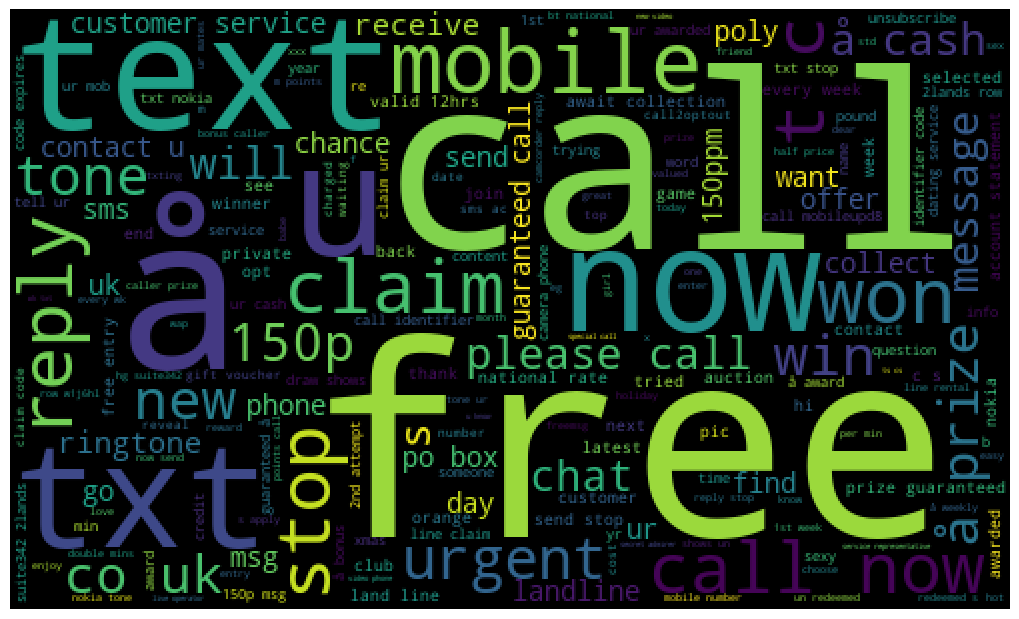

In [11]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

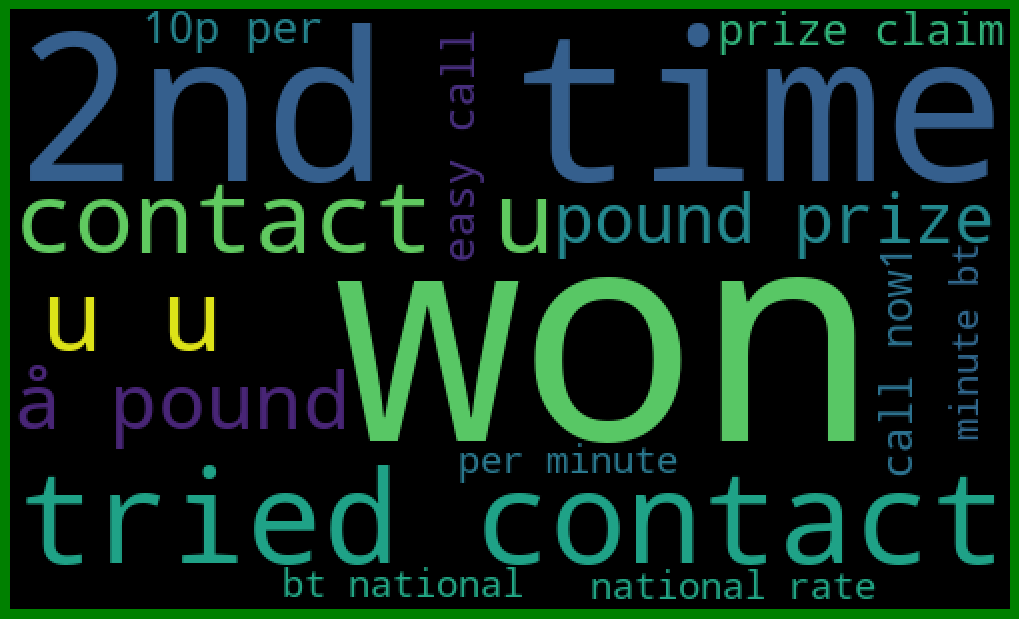

In [12]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [13]:
data = data.replace(['ham','spam'],[0, 1]) 

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [15]:
#remove the punctuations and stopwords
import string
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [16]:
data['text'] = data['text'].apply(text_process)

In [17]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])
label

,label
0,0
1,0
2,1
3,0
4,0
...,...
5567,1
5568,0
5569,0
5570,0


In [18]:


from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  11305


In [19]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'going', 'one', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ì', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell', 'take', 'much', 'night', 'way', 'Hey', 'reply', 'work', 'make', 'give', 'new']


In [20]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [34]:
word2idx

{'u': 0,
 '2': 1,
 'call': 2,
 'U': 3,
 'get': 4,
 'Im': 5,
 'ur': 6,
 '4': 7,
 'ltgt': 8,
 'know': 9,
 'go': 10,
 'like': 11,
 'dont': 12,
 'come': 13,
 'got': 14,
 'time': 15,
 'day': 16,
 'want': 17,
 'Ill': 18,
 'lor': 19,
 'Call': 20,
 'home': 21,
 'send': 22,
 'going': 23,
 'one': 24,
 'need': 25,
 'Ok': 26,
 'good': 27,
 'love': 28,
 'back': 29,
 'n': 30,
 'still': 31,
 'text': 32,
 'im': 33,
 'later': 34,
 'see': 35,
 'da': 36,
 'ok': 37,
 'think': 38,
 'Ì': 39,
 'free': 40,
 'FREE': 41,
 'r': 42,
 'today': 43,
 'Sorry': 44,
 'week': 45,
 'phone': 46,
 'mobile': 47,
 'cant': 48,
 'tell': 49,
 'take': 50,
 'much': 51,
 'night': 52,
 'way': 53,
 'Hey': 54,
 'reply': 55,
 'work': 56,
 'make': 57,
 'give': 58,
 'new': 59,
 'number': 60,
 'already': 61,
 'great': 62,
 'right': 63,
 'ask': 64,
 'Hi': 65,
 'say': 66,
 'tomorrow': 67,
 '1': 68,
 'amp': 69,
 'well': 70,
 'claim': 71,
 'said': 72,
 'txt': 73,
 'Oh': 74,
 'Good': 75,
 'message': 76,
 'didnt': 77,
 'Txt': 78,
 'e': 79,
 'p

In [21]:
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [22]:
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])
word_vectors.shape

(5572, 11305)

In [33]:
word_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 9376)

In [24]:
#features = word_vectors
features = vectors

In [25]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.2, random_state=111)

In [26]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [27]:

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [28]:

clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}
#fit the data onto the models
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [29]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [30]:
pred_scores_word_vectors

[('SVC', [0.979372197309417]),
 ('KN', [0.9345291479820628]),
 ('NB', [0.9856502242152466]),
 ('DT', [0.957847533632287]),
 ('LR', [0.9524663677130045]),
 ('RF', [0.9757847533632287])]

In [31]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [38]:
newtext = ["Hello world"]
integers = vectorizer.transform(newtext)
x = mnb.predict(integers)
find(x)        

Message is NOT Spam
